# Optimal Selection of Sparse Mean-reverting Portfolios

## Intro
This work is inspired by the academic paper by Marco Cuturi and Alexandre d'Aspremont   ["Mean-Reverting Portfolios: Tradeoffs Between Sparsity and Volatility"](https://arxiv.org/abs/1509.05954). The paper describes multiple optimisation techniques that allow selecting sparse mean-reverting portfolios with pre-defined volatility characteristics. A numerical experiment included in the paper is based on historical data of daily implied volatility. The calculations below have extended the numerical experiment to mean-reverting portfolios of stock using a sample of S&P 500 companies. Additionally, it demonstrates the sensitivity of resulting portfolios to optimisation parameters that allowed for a better understanding of the internal structure of the approach.

We further focus on practical aspects of mean-reverting stock portfolio construction and include minimum theoretical facts to follow the logic. Please refer to Cuturi and d'Aspermont paper for more details behind the theory.

## Defining Target Portfolio

Our primary target is to build a portfolio that exhibits significant mean reversion. This portfolio includes long and short positions in multiple liquid stocks from a pre-defined universe. The portfolio is defined as a vector of weights that should be optimised in a way that allows for: <br>
- **Significant mean reversion**. The portfolio has to revert to the long-term mean. We control the level of mean reversion based on the p-value of *Augmented Dickey–Fuller test (ADF)*. This measure is not suitable for optimisation, hence different proxies based on stationarity measures are used. 
- **Sufficient volatility**. A mean reversion trading strategy makes money on extreme deviations from a long-term mean. Hence we need a portfolio that deviates significantly from the long-term mean, so a potential trading strategy does not need to be highly-leveraged to be profitable. 
- **Sparsity**. The portfolio requires trading of as few assets as possible, that will allow minimising cost. Going forward, we introduce a constraint for the maximum number of stocks in the portfolio.


In [0]:
%matplotlib inline
# Imports
from datetime import datetime, timedelta, date
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy import linalg as LA
import time
from scipy.stats.stats import pearsonr

import cvxpy as cp
from sklearn.decomposition import SparsePCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [0]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

## Source Data

We begin with downloading historical adjusted close prices of a random sample of 50 symbols from the most recent S&P 500 index, using Yahoo Finance as a data source. Historical period is from _1-Jan-2018_ to _1-Jun-2019_.

Theoretically, the approach is scalable and should allow building a mean-reverting portfolio based on a larger base of stocks, but larger dataset will limit our ability to iterate quickly across multiple techniques. 

In [0]:
#Get the most recent S&P 500 index from Wikipedia
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header=0)[0] # returns a list for each table

In [0]:
symbols = [x for x in sp.Symbol if x.find(".")==-1]
#Pick random sample of 50 symbols
random.seed(123)
np.random.seed(5)
assets_list_short = random.sample(symbols, 50)
print('Assets selected: {}'.format(assets_list_short))

start = datetime(2018, 1, 1)
end = datetime(2019, 6, 1)
src_data = pdr.data.DataReader(assets_list_short, 'yahoo', start=start, end=end)

#Simple impute
from sklearn.impute import SimpleImputer
s_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

#Keep only adjusted close price and convert to Numpy array
x_array = np.array(src_data['Adj Close'])
x_array = s_imp.fit_transform(x_array)
# Centered data
x_array_centered = x_array - np.nanmean(x_array, axis=0)

Assets selected: ['MO', 'CMI', 'AON', 'RTN', 'BEN', 'CSX', 'AIZ', 'SNPS', 'UTX', 'TDG', 'ALLE', 'FE', 'K', 'LRCX', 'EA', 'EFX', 'FTI', 'BR', 'BDX', 'ETR', 'ORCL', 'CXO', 'COG', 'ABT', 'UNM', 'HBI', 'REG', 'TRIP', 'MMC', 'FITB', 'AMP', 'ACN', 'DUK', 'PXD', 'HCP', 'ARNC', 'LNT', 'AIV', 'NWS', 'BLK', 'BLL', 'ROP', 'VFC', 'AFL', 'DFS', 'VAR', 'GS', 'LIN', 'HBAN', 'CCI']


## Utility Functions



### Autocovariance Matrix for Multivariate Process

All of the techniques below use lagged autocovariance matrices as core building blocks. An empirical lag-k autocovariance matrix for a multivariate time series $\{x_t\}$ is defined as follows:

$A_k=\frac{1}{T-k-1}\sum_{t=1}^{T-k} \tilde{x}_t\tilde{x}_{t+k}^T$, <br>
$\tilde{x_t}=x_t-\frac{1}{T}\sum_{t=1}^{T}x_t$

In [0]:
# Build autocovariance matrix
def autocovariance_matrix(x, k=0):
    T = x.shape[0]
    x_tilde = x - np.nanmean(x, axis=0)

    x_0 = x_tilde[0,:].reshape((1,x_tilde.shape[1]))
    
    if k > 0:
        A_k = 1/(T - k - 1) * np.dot(x_tilde[k:,:].transpose(), x_tilde[:-k])
    else:
        A_k = 1/(T - 1) * np.dot(x_tilde.transpose(), x_tilde)
    return A_k


In [0]:
autocovariance_matrix(x_array, 0).shape

(50, 50)

### Plot Time Series and Present Basic Performance Stats

We use the function below to inspect the performance of the resulting portfolios. As mentioned, we are focusing on variance and ADF p-value as primary performance measures of the portfolio.

In [0]:
# Plot time series with basic stats
def plot_mr_ts(ts, label):
    var_ = np.var(ts)
    adf_ = adfuller(ts)
    plt.plot(ts, label='{}; Var:{:.0f} ADF p:{:.3f}'.format(label, var_, adf_[1]))
    plt.ylabel('Close')
    plt.legend()
    plt.show()


## Proxies for Mean Reversion

Given a multivariate n-dimensional time series $x=\{x_t\}$, we need to find the weights $y = \{y_1...y_n\}$ such that the univariate time series $(y^Tx_t )$ is stationary.
Following Cuturi and d'Aspermont we define two proxies for stationarity of time series to derive the optimal values of $y$: <br>
- Predictability
- Portmanteau criterion



### Predictability

We target to minimise predictability of the univariate process $(y^T, x_t)_t$, with weights $y \in \mathbb{R}^n$.
General predictability is defined based on the time series decomposition 
${x}_t = \hat{x}_{t-1} + \varepsilon_t$ 
, where $\hat{x}_{t-1}$ is a predictor of $x_t$ built upon past values recorded up to $t-1$. 

Predictability is defined as $\lambda = \frac{\hat{\sigma}^2}{\sigma}$
, where $\sigma^2$ and $\hat{\sigma}^2$ are variances of ${x}_t$ and $\hat{x}_{t-1}$ respetively. <br>
If we assume the process to be _VAR(1)_, this task is equivalent to computing the smallest eigenvector of the _prediction matrix_ $A_0^{-1/2}A_1A_0^{-1}A_1^TA_0^{-1/2}$, where $A_0, A_1$ are 0- and 1-lag autocovariance matrices respectively.
Below we demonstrate the portfolio derived from the source data based on minimum predictability criterion. Note we don't control sparsity and volatility at this stage.

In [0]:
A0 = autocovariance_matrix(x_array, 0)
A1 = autocovariance_matrix(x_array, 1)

In [0]:
# Minimise predictability
A0_inv = LA.inv(A0)
A0_inv_sqrt = sqrtm(A0_inv)

pred_mat = A0_inv_sqrt.dot(A1).dot(A0_inv).dot(np.transpose(A1)).dot(A0_inv_sqrt)

v, w = LA.eig(pred_mat)
min_eig = w[np.argmin(v)]
max_eig = w[np.argmax(v)]

print("Eigenvalues of prediction matrix:")
print(v)

Eigenvalues of prediction matrix:
[0.04439897 0.06661787 0.06928859 0.10340457 0.15661698 0.18516661
 0.22235811 0.2333894  0.25506974 0.29179904 0.31441755 0.36018902
 0.38297217 0.41401936 0.43041001 0.47230768 0.4975416  0.50778679
 0.53307252 0.56845715 0.60042845 0.63633199 0.63970237 0.65204502
 0.6755294  0.68825676 0.72525922 0.7373515  0.7457611  0.78669457
 0.80893434 0.82741361 0.84828813 0.86824503 0.87339839 0.88962923
 0.90278375 1.00360022 1.00283268 0.99735096 0.99555185 0.98817648
 0.98446958 0.97869338 0.97216496 0.91769597 0.95888716 0.93305612
 0.94652756 0.94468937]


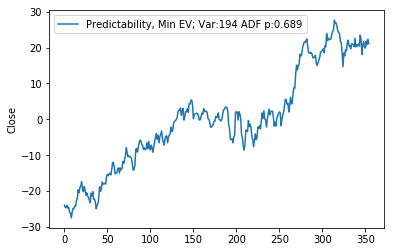

In [0]:
mr_portf_min = x_array_centered.dot(min_eig)
mr_portf_max = x_array_centered.dot(max_eig)

plot_mr_ts(mr_portf_min, 'Predictability, Min EV')

The graph presents the performance of the derived portfolio. As can be observed, the result is poor in terms of mean-reversion properties, with very high ADF p-value. 

### Portmanteau Criterion

Portmanteau criterion relaxes the requirement for a process to be _VAR(1)_ as defined in Predictability-based calculation above. Portmanteau statistic of order $p$ of a centered multivariate process is defined as <br>
$por_p(y^Tx)=\frac{1}{p}\sum_{i=1}^{p}{(\frac{y^TA_iy}{y^TA_0y})}^2$  
In univariate settings Portmanteau criterion corresponds to the average of up to lag-p squared autocorrelations.
There is no closed form solution for minimum Portmanteau criterion, so to demonstrate its work we select two stocks that exhibit the lowest and highest Portmanteau statistics of order 5.

In [0]:
#Portmanteau criterion for univariate time series
def portmanteau(ts_array, n):
    '''
    ts_array = multivariate time series
    n = order of Portmanteau statistics to be calculated
    '''
    autocorr = [pearsonr(ts_array[:-t], ts_array[t:])[0] for t in range(1, n + 1)]
    return np.sum(np.square(autocorr)) / n

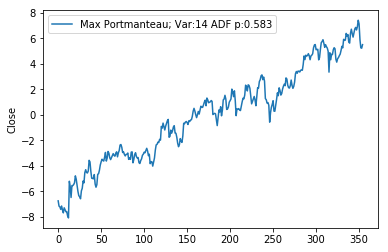

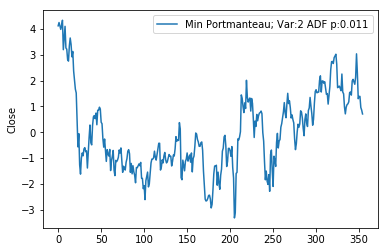

In [0]:
#Find the most and the least mean-reverting stock as per Portmenteau statistic
x_centered = x_array - np.nanmean(x_array, axis=0)
pmt_symb = [portmanteau(x_centered[:, i], 50) for i in range(x_centered.shape[1])]

plot_mr_ts(x_centered[:, np.argmax(pmt_symb)], 'Max Portmanteau')
plot_mr_ts(x_centered[:, np.argmin(pmt_symb)], 'Min Portmanteau')


Portmanteau statistics allows selecting stocks with good mean reversion characteristics. We further move on to apply Predictability and Portmanteau statistics to derive optimal mean-reverting portfolios.

## Optimal Mean Reverting Portfolio

Optimisation task to derive optimal mean reverting portfolios under variance and sparsity constraints for both Predictability and Portmanteau criterion are formulated in [Cuturi and d'Aspremont]. It is noted that both problems are non-convex since they involve sparse selection of variables. Base on this it is suggested to apply convex relaxation of these problems. This results in semidefinite programs (SDPs) as presented below:<br>
- **Predictability:** <br>
minimise $Tr(MY) + \rho\|Y\|_1$ <br>
subject to $Tr(A_0Y) \ge \nu$ <br>
$Tr(Y) = 1, Y \succcurlyeq 0$ 
- **Portmanteau:** <br>
minimise $\sum_{i=1}^p{Tr(A_iY)^2} + \rho\|Y\|_1$ <br>
subject to $Tr(A_0Y) \ge \nu$ <br>
$Tr(Y) = 1, Y \succcurlyeq 0$ 

In the tasks above <br>
- $Y$ is the target $n\times n$ positive semidefinite matrix
- $\nu$ is the minimum required variance of the resulting portfolio
- $\rho$ is the weight of penalty for L1-norm of $Y$
- $M=A_1A_0^{-1}A_1^T$

With nonnegative $\rho$ the optimiser will try to shrink $Y$ that theoretically should result in a sparser portfolio. <br>
Compared to the original definition of the optimisation problem, we replaced the _L1_ norm with _L2_ norm in the target function for the Portmanteau criterion. This allowed for better convergence and quicker solving of the optimisation task. As demonstrated further, _L2_ norm still performs well in shrinking $Y$ and provides for a sparser portfolio.
We further recover the solution $y^*$ from the corresponding SDP solution $Y^*$. As suggested in [Cuturi and d'Aspremont], we use _Sparse PCA_ process to derive $y^*$ as a maximum sparse principal component of $Y^*$.<br> Sparse PCA implementation in _scikit-learn_ package relies on the parameter _alpha_ to define the level of the sparsity of resulting principal components. 

The optimisation tasks are solved using __[CVXPY](https://www.cvxpy.org/index.html)__ package. In all cases below, we require minimum required variance $\nu$ of _50_ and keep $\rho$ to be _1_. We set _alpa_ parameter of Sparse PCA to be _0.05_. These parameters are taken arbitrarily to demonstrate the approach. We further analyse the impact of $\rho$ on the optimisation results and also demonstrate the connection between $\rho$ and _alpha_.


### Predictability Criterion

In [0]:
M = A1.dot(A0_inv).dot(np.transpose(A1))

Y = cp.Variable(M.shape, symmetric=True)
rho = 1 #weight of l1 norm penalty
nu = 50 #minimum required variance


target_pred = cp.trace(M @ Y) + rho * cp.norm(Y, 1)

constraints_pred = [Y >> 0]
constraints_pred += [cp.trace(A0 @ Y) >= nu]
constraints_pred += [cp.trace(Y) == 1]

prob_pred = cp.Problem(cp.Minimize(target_pred), 
                       constraints_pred)

prob_pred.solve()

Y_pred = Y.value

In [0]:
sp_pca = SparsePCA(n_components=1, alpha=0.05)
sp_pca.fit(Y_pred)
print("Maximum sparse principal component:")
print(sp_pca.components_[0])
n_stock_pred = np.sum([x != 0 for x in sp_pca.components_[0]])
wgt_pred = sp_pca.components_[0]/sum(sp_pca.components_[0])
print("Total number of stocks in portfolio: {}".format(n_stock_pred))

Maximum sparse principal component:
[-0.10348953  0.          0.          0.         -0.01332388 -0.00635344
  0.08942403  0.          0.         -0.1268705   0.         -0.120183
  0.          0.          0.00420809  0.          0.          0.
 -0.15040782  0.          0.          0.08213342  0.15366347  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.06950135  0.
  0.          0.          0.         -0.01551844  0.         -0.07844616
  0.          0.05026104  0.         -0.15007466  0.          0.
 -0.13518714  0.        ]
Total number of stocks in portfolio: 16


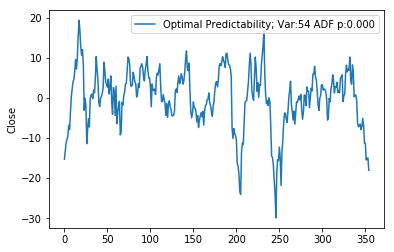

In [0]:
mr_pred = x_array_centered.dot(wgt_pred)
plot_mr_ts(mr_pred, 'Optimal Predictability')


We can observe the resulting portfolio is both sufficiently mean reverting and volatile. Target variance is achieved using a sparse portfolio of 16 stocks.

### Portmanteau Criterion

In [0]:
rho_port = 0.2 #weight of matrix norm penalty
nu_port = 50 #minimum required variance
n_a = 5 #Number of autoregressive components to consider

print('Target variance: {}'.format(nu_port))

Y_port = cp.Variable(A0.shape, PSD=True) #symmetric=True

target_port = rho_port * cp.norm(Y_port, 2)
for i in range(1, n_a + 1):
    A_i = autocovariance_matrix(x_array, i)
    target_port += cp.square(cp.trace(cp.matmul(A_i, Y_port)))
    
constraints_port = [Y_port >> 0]
constraints_port += [cp.trace(cp.matmul(A0, Y_port)) >= nu_port]
constraints_port += [cp.trace(Y_port) == 1]

prob_port = cp.Problem(cp.Minimize(target_port), 
                       constraints_port)

res_solve_port = prob_port.solve(verbose=False, max_iters=int(1e4), parallel=True)

Target variance: 50


In [0]:
print("Trace(Y):\t{:.2f}".format(np.trace(Y_port.value)))
print("Volatility:\t{:.2f}".format(np.trace(np.dot(A0, Y_port.value))))

print("L2 norm of Y:\t{:.2f}".format(LA.norm(Y_port.value, 2)))

Trace(Y):	1.00
Volatility:	50.00
L2 norm of Y:	1.00


In [0]:
sp_pca_port = SparsePCA(n_components=1, alpha=0.1)
sp_pca_port.fit(Y_port.value)
print("Maximum sparse principal component:")
print(sp_pca_port.components_[0])
wgt_port = sp_pca_port.components_[0]/sum(sp_pca_port.components_[0])
n_stock_port = np.sum([x != 0 for x in sp_pca_port.components_[0]])
print("Total number of stocks in portfolio: {}".format(n_stock_port))

Maximum sparse principal component:
[-0.13047828  0.          0.          0.          0.          0.
  0.06028339 -0.11343345  0.         -0.39733669  0.         -0.18534396
  0.         -0.03525146  0.          0.          0.          0.
 -0.08510655  0.          0.          0.04477017  0.22733038  0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.11568888  0.          0.          0.
  0.          0.          0.          0.          0.         -0.08851679
  0.12824226  0.02359511  0.05420747 -0.14146403  0.          0.0696808
 -0.14286604  0.        ]
Total number of stocks in portfolio: 17


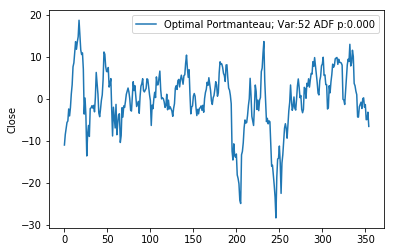

In [0]:
mr_port = x_array_centered.dot(wgt_port)

plot_mr_ts(mr_port, 'Optimal Portmanteau')

Similar to the previous result, the Portmanteau optimal solution achieves both volatility and mean reversion using a sparse portfolio of 17 stocks.

## Sensitivity to Parameters

We demonstrated that both Predictability and Portmanteau criteria allow building meaningful mean-reverting portfolios that satisfy target criteria. We further analyse the impact of input parameters on the solution and check how it can be improved by tuning the parameters. We focus on the Portmanteau criterion in further analysis. <br>
### Questions
The optimisation task depends on several input parameters that may impact the outcome. Some particular questions to research further are: <br>
- What is the best value of matrix norm penalty parameter  $\rho$ and when it begins to impact the optimisation solution;
- Two parameters define the sparsity of the outcome portfolio. First, we penalise the norm of $Y$ in the optimisation task. Second, we apply sparsity controlling parameter _alpha_ when deriving sparse principal components. Intuitively we expect that higher matrix norm penalty will allow applying lower sparsity controlling parameter in Sparse PCA. To validate this, we introduce a function that finds the _alpha_ parameter based on the required number of non-zero elements in the resulting sparse principal component. With the number of non-zero elements fixed, we apply different matrix norm penalty weights and check how they impact the derived _alpha_ parameter. 

We define two utility functions that are further used in the sensitivity analysis.

In [0]:
# Search for Sparse PCA alpha parameter that provides no more than required number of features in sparse maximum principal component
def spca_alpha(Y_matrix, max_features, eps = 1e-4):
    """
    Y_matrix = input matrix
    max_features = maximum number of non-zero elements in the first sparse principal component
    eps = convergence parameter
    """
    range_ = [0,1]

    while True:
        range_mid = 0.5 * (range_[1] + range_[0])

        sp_pca_mid = SparsePCA(n_components=1, alpha=range_mid)
        sp_pca_mid.fit(Y_matrix)
        n_features_mid = sum([x != 0 for x in sp_pca_mid.components_[0]])

        if n_features_mid == max_features:
            return range_mid
        elif range_[1] - range_[0] < eps:
            return None
        elif n_features_mid < max_features:
            range_[1] = range_mid
        else:
            range_[0] = range_mid


In [0]:
# Solve PSD problem for Portmanteau criterion
def portmanteau_matrix(X, rho_port, nu_port, n_a, A0):  
    """
    X = source data
    rho_port = weight of L2 norm penalty
    nu_port = minimum required variance
    n_a = number of autoregressive components to consider
    A0 = zero lag covariance matrix
    """
    Y_port = cp.Variable(A0.shape, PSD=True)

    target_port = rho_port * cp.norm(Y_port, 2)
    for i in range(1, n_a + 1):
        A_i = autocovariance_matrix(x_array, i)
        target_port += cp.square(cp.trace(cp.matmul(A_i, Y_port)))

    constraints_port = [Y_port >> 0]
    constraints_port += [cp.trace(cp.matmul(A0, Y_port)) >= nu_port]
    constraints_port += [cp.trace(Y_port) == 1]

    prob_port = cp.Problem(cp.Minimize(target_port), 
                           constraints_port)

    res_solve_port = prob_port.solve(verbose=False, max_iters=int(5e6))
    print('Optimization target:\t{:.3f}'.format(res_solve_port))
    return Y_port.value

### Grid Search Process

Let's assume we target to build a mean-reverting portfolio using no more than 10 stocks. For a range of matrix norm penalty weights $\rho$ and with the target variance $\nu$ fixed, we derive the following outcomes: <br>
- _alpha_ parameter of Sparse PCA providing for the required sparsity
- L2 norm of the solution $Y^*$
- p-value of ADF test
- variance of the derived mean-reverting portfolio <br>

With no prior expectations of the best value of $\rho$ we apply a grid search in the range _[0, 1000]_. For each value of $\rho$ we track the outcome of optimisation solution.

In [0]:
#Impact of matrix norm penalty on required Sparce PCA alpha and derived portfolio variance
target_variance = 50 #Target variance of the portfolio
target_nsymb = 10 #Target number of stocks selected for the portfolio
rho_grid = np.linspace(0, 1000, 20)

l_vars = [] #Resulting variances
l_alphas = [] #Resulting Sparse PCA aphas to derive target_nsymb in the MR portfolio 
l_traces = [] #Resulting traces
l_adf_p = [] #Resulting ADF p-value
l_norms = [] #Resulting matrix L2 norm
l_matr = [] #Resulting Y matrix parameter

for rho in rho_grid:
    print('Target rho:\t{:.3f}'.format(rho))
    port_res = portmanteau_matrix(x_array, rho, target_variance, 3, A0)
    alpha = spca_alpha(port_res, target_nsymb, eps = 1e-4)
    sp_pca_port = SparsePCA(n_components=1, alpha=alpha)
    sp_pca_port.fit(port_res)
    wgt_port = sp_pca_port.components_[0]/sum(sp_pca_port.components_[0])
    mr_portf = x_array.dot(wgt_port)
    var = np.var(mr_portf)
    adf_p = adfuller(mr_portf)[1]
    
    l_vars += [var]
    l_alphas += [alpha]
    l_traces += [np.trace(np.dot(A0, port_res))]
    l_adf_p += [adf_p]
    l_norms += [LA.norm(port_res, 2)]
    l_matr += [port_res]

Target rho:	0.000
Optimization target:	4085.501
Target rho:	52.632
Optimization target:	4138.130
Target rho:	105.263
Optimization target:	4190.767
Target rho:	157.895
Optimization target:	4243.402
Target rho:	210.526
Optimization target:	4296.024
Target rho:	263.158
Optimization target:	4348.666
Target rho:	315.789
Optimization target:	4388.306
Target rho:	368.421
Optimization target:	4415.351
Target rho:	421.053
Optimization target:	4441.620
Target rho:	473.684
Optimization target:	4467.940
Target rho:	526.316
Optimization target:	4494.272
Target rho:	578.947
Optimization target:	4520.562
Target rho:	631.579
Optimization target:	4546.883
Target rho:	684.211
Optimization target:	4573.218
Target rho:	736.842
Optimization target:	4598.982
Target rho:	789.474
Optimization target:	4619.912
Target rho:	842.105
Optimization target:	4637.483
Target rho:	894.737
Optimization target:	4655.024
Target rho:	947.368
Optimization target:	4672.576
Target rho:	1000.000
Optimization target:	4690.108


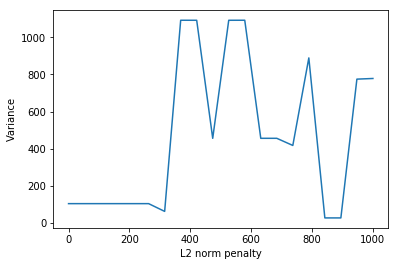

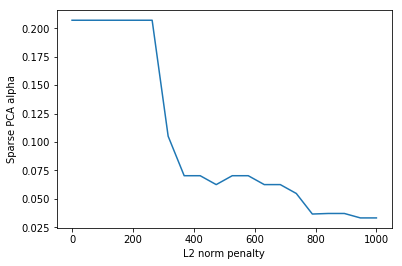

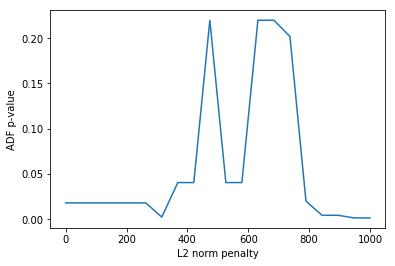

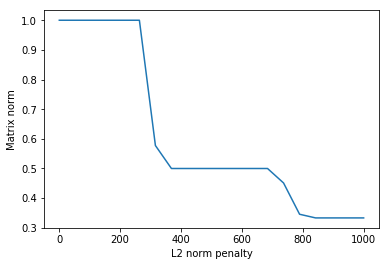

In [0]:
plt.plot(rho_grid, l_vars)
plt.ylabel('Variance')
plt.xlabel('L2 norm penalty')
plt.show()

plt.plot(rho_grid, l_alphas)
plt.ylabel('Sparse PCA alpha')
plt.xlabel('L2 norm penalty')
plt.show()

plt.plot(rho_grid, l_adf_p)
plt.ylabel('ADF p-value')
plt.xlabel('L2 norm penalty')
plt.show()

plt.plot(rho_grid, l_norms)
plt.ylabel('Matrix norm')
plt.xlabel('L2 norm penalty')
plt.show()

The graph of _Matrix norm_ demonstrates the result of the optimisation task begins to be sensitive to matrix norm penalty from the value of $\rho=263$. In line with the expectations, increasing $\rho$ results in decreasing matrix norm of $Y^*$. <br>
The graph of _Sparse PCA alpha_ confirms the hypothesis of the relationship between the _alpha_ parameter of the Sparse PCA function and the matrix norm penalty in the optimisation task. We see that the higher matrix norm penalty implies lower _alpha_ to derive the same sparsity of the resulting portfolio.

### Optimal Portfolio

Based on the grid search results, we check how well we can do in finding the volatile mean-reverting portfolio. To demonstrate that, we select the portfolio with the lowest ADF p-value. We can see the resulting portfolio has significantly better properties than the one found with arbitrary optimisation parameters, still using no more than 10 stocks. 

In [0]:
N = np.argmin(l_adf_p)
rhoN = rho_grid[N]
port_resN = l_matr[N]

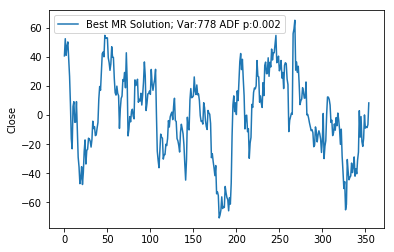

In [0]:
alphaN = l_alphas[N]
sp_pca_portN = SparsePCA(n_components=1, alpha=alphaN)
sp_pca_portN.fit(port_resN)
wgt_portN = sp_pca_portN.components_[0]/sum(sp_pca_portN.components_[0])
mr_portfN = x_array_centered.dot(wgt_portN)

plot_mr_ts(mr_portfN, 'Best MR Solution')

## Next Steps

We tried some interesting techniques for building mean-reverting portfolios. We demonstrated how well these techniques can do on the historical sample. Obvious next step would be to run out-of-sample tests to check how stable these results are. This may potentially involve some further tuning of parameters. <br>
We also keep in mind that all the results above were derived on a random selection of 50 candidate stocks. More work required to fully automate the selection of optimal sparse portfolio on a wider range of instruments. <br>